##                                                        Final Project
  
### Project Overview:
The purpose of the project is to see whether smalls businesses create more jobs in California. We use QWI (Quarterly Workforce Indicator), published by the US Census Bureau, as the main data source. Multiple linear regression models will be tested to better capture and isolate covariances between regressors.
#### (Important variables)
The depandent variable in the regression model will be the net job creation. This is calculated by subtracting number of hirings for replacement from the total number of hirings. 

The independent variable will be the proportion of employment of small firms with respect to the total employment in the county. This variable is to reflect the weighted proportion of small businesses. 

The first set of controlled variables will include the proportion of employments of medium sized and large firms. 

The second controlled variable is the education contribution level for each small firms. This is calculated by the number of employments with education level higher than or equal to undergraduate level divided by the total employments of small firms. 

The third controlled variable will be a dummy variable indicating the financial crisis from 2008 to 2010. 
### Project Structure:
#### (Introduction) 
The project will start with data description, which will include descriptive statistics for each variable. Also, the data structure of QWI will be briefly introduced since there are randoms distortions added for the confidentiality purpose. It is neccessary to consider this kind of error factors.
#### (Methodology) 
The second part will introduce main data process methodology including processing missing data and processing "significantly distorted value". Also, variables from the raw dataset will be processed to better eliminate factors that will affect the robustness of the regression, such as seasonality. After these steps, we can present the final processed dataset with simple descriptive statistics such as mean, variance, correlation and covariance. 
#### (Results) 
The third part will be constructing regression models. Both linear and logistic regression models will be tested with different regressor inputs. 
#### (Discussion) 
The fourth part will be checking the robustness of different regression models and the significance of important coefficients. Robustness testing will include the discussion of adjusted-R, covariance matrix and BIC so that the most preferred model could be selected. Also, the significance will be tested using t-test on important coefficients. 
#### (Conclusion) 
The final part will be interpreting the results in case of real-life suggestions and implications. Sugesstions for future research will be included as well.




# 1. Introduction
Job creation has been a central topic in politics, economics, even on people's dinner tables for a long time. People always want a higher job creation rate. However, defining job creation itself is a complicated task consedering there are continuous job destructions and rehirings happening in the job market. Therefore, a more careful and comprehensive approach is needed to better explain the concept of job creation. On top of that, this research contains statistical analysis on the factors that lead to a higher job creation. The hypotheis is that micro and small firms have a higher contribution to job creation. 

The dataset is from QWI (Quarterly Workforce Indicators) published by the US Census Bureau. It contains time-series data on the establishment level from 1991 to 2019. The quarterly indicators include job changes on firm levels and on individual levels. One specific thing worths mentioning is that the dataset contains artificially distorted data in order to protect the confidentiality of firms. Also, some data at in early years are missing. Therefore, these two factors will affect the quality of the dataset, and we will process these factors to minimized their impact.

We will use the unpooled OLS linear regression model to visualize the contribution of micro and small firms. For the result to be robust, different sets of controlled variables including knowledge contribution, job creation by firms of other sizes, and the factor of major financial crisis or business cycles are included in the regression model. Specific explanations of these important variables will be included in the later sessions. 

# 2. Key Imports and Data Access

## 2.1 Key Imports
We used some famous Python libraries including NumPy, Pandas, and so on for data analysis, regression analysis and data visualization.

In [1]:
#key imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.stats.api as sms
import seaborn as sns

from statsmodels.iolib.summary2 import summary_col, summary_params
from statsmodels.compat import lzip
from statsmodels.graphics.gofplots import ProbPlot

In [2]:
#highlight extension

## 2.2 Data Access
We will access multiple datasets since we want to make each step as clear as possible while ensuring the accurateness of the dataset. 

In [3]:
#access data
url = 'https://ledextract.ces.census.gov/request/fcd21b06a1c84d3abb76e4bcd5ea8009.csv'
raw_data = pd.read_csv(url)


In [4]:
#access data for calculating knowledge contribution
url_2 = 'https://ledextract.ces.census.gov/request/9cb0b21c249a4b2f9c2f44b71e10d05f.csv'
raw_edu = pd.read_csv(url_2)

In [5]:
#access data for calculating average change in earnings 
url_3 = 'https://ledextract.ces.census.gov/request/fc813143e3eb473887881e1df90ab55b.csv'
raw_earns = pd.read_csv(url_3)

In [6]:
#access data
#raw_data = pd.read_csv('dataset_1.csv')

# 3. Reformatting and Data Cleaning
## 3.1 Missing Values
There are many missing values in the dataset as shown by the overview. Therefore, we would like to ignore certain groups that contain a significant amount of missing values (20%). Although imputation is a preferred method, we will simply drop certain groups since it remains consistant across the whole dataset and our sample size will not be affected significantly.

In [7]:
#get an overview of the dataset
raw_data.head()

,periodicity,seasonadj,geo_level,geography,ind_level,industry,ownercode,sex,agegrp,race,ethnicity,education,firmage,firmsize,year,quarter,Emp,EmpEnd,sEmp,sEmpEnd
0,Q,U,C,6001,A,0,A05,0,A00,A0,A0,E0,0,0,1991,3,NaN,447034.0,-1,1
1,Q,U,C,6001,A,0,A05,0,A00,A0,A0,E0,0,1,1991,3,NaN,98791.0,-1,1
2,Q,U,C,6001,A,0,A05,0,A00,A0,A0,E0,0,2,1991,3,NaN,51407.0,-1,1
3,Q,U,C,6001,A,0,A05,0,A00,A0,A0,E0,0,3,1991,3,NaN,79477.0,-1,1
4,Q,U,C,6001,A,0,A05,0,A00,A0,A0,E0,0,4,1991,3,NaN,23357.0,-1,1


In [8]:
raw_edu.head()

,periodicity,seasonadj,geo_level,geography,ind_level,industry,ownercode,sex,agegrp,race,ethnicity,education,firmage,firmsize,year,quarter,Emp,EmpEnd,sEmp,sEmpEnd
0,Q,U,C,6001,A,0,A05,0,A00,A0,A0,E0,0,0,1991,3,NaN,447034.0,-1,1
1,Q,U,C,6001,A,0,A05,0,A00,A0,A0,E4,0,0,1991,3,NaN,119630.0,-1,1
2,Q,U,C,6003,A,0,A05,0,A00,A0,A0,E0,0,0,1991,3,NaN,139.0,-1,1
3,Q,U,C,6003,A,0,A05,0,A00,A0,A0,E4,0,0,1991,3,NaN,22.0,-1,9
4,Q,U,C,6005,A,0,A05,0,A00,A0,A0,E0,0,0,1991,3,NaN,5857.0,-1,1


In [9]:
raw_earns.head()

,periodicity,seasonadj,geo_level,geography,ind_level,industry,ownercode,sex,agegrp,race,ethnicity,education,firmage,firmsize,year,quarter,EarnS,sEarnS
0,Q,U,C,6001,A,0,A05,0,A00,A0,A0,E0,0,0,1991,3,NaN,-1
1,Q,U,C,6003,A,0,A05,0,A00,A0,A0,E0,0,0,1991,3,NaN,-1
2,Q,U,C,6005,A,0,A05,0,A00,A0,A0,E0,0,0,1991,3,NaN,-1
3,Q,U,C,6007,A,0,A05,0,A00,A0,A0,E0,0,0,1991,3,NaN,-1
4,Q,U,C,6009,A,0,A05,0,A00,A0,A0,E0,0,0,1991,3,NaN,-1


In [10]:
#we observe that there are several columns that are not out interested variables, such as periodicity, seasonadj.
#so we want to keep only those useful columns.
raw_data = raw_data[['geography','firmsize','year','quarter','Emp','EmpEnd','sEmp','sEmpEnd']]
raw_data.head()

,geography,firmsize,year,quarter,Emp,EmpEnd,sEmp,sEmpEnd
0,6001,0,1991,3,NaN,447034.0,-1,1
1,6001,1,1991,3,NaN,98791.0,-1,1
2,6001,2,1991,3,NaN,51407.0,-1,1
3,6001,3,1991,3,NaN,79477.0,-1,1
4,6001,4,1991,3,NaN,23357.0,-1,1


In [11]:
#check missing values
raw_data.isna().sum()

geography      0
firmsize       0
year           0
quarter        0
Emp          945
EmpEnd       605
sEmp           0
sEmpEnd        0
dtype: int64

In [12]:
#check the pattern of missing values
def pct_na (a):
    '''return the percentage of the number of missing values for a specified array'''
    
    number_of_entris = len(a)
    number_of_na = a.isna().sum()
    result = number_of_na/number_of_entris
    
    return result

def ms_values (dataset, group_name, var_names):
    """return a DataFrame containing the percentage of missing values for variables var_names by the group group_name"""
    
    #group the DataFrame by group_name
    grouped = dataset.groupby([group_name])
    
    #generate the return object
    columns = [group_name] + var_names
    ms = np.empty([len(grouped),len(var_names)+1])

    #apply pct_na on each group (i.e. each year)
    column_index = 0
    for i in columns:
        row_index = 0
        for j in grouped.groups:
            if column_index == 0:
                ms[row_index,column_index] = j
            else:
                a = grouped.get_group(j)
                ms[row_index,column_index] = pct_na(a[i])
            row_index +=1
        column_index += 1
    
    ms = pd.DataFrame(ms,columns=columns)
    return ms

In [13]:
#then we display missing values by county and year

ms_county = ms_values(raw_data,'geography',['Emp','EmpEnd'])
ms_year = ms_values(raw_data,'year',['Emp','EmpEnd'])

In [14]:
print('Percentage of missing values by county')
ms_county.head()

Percentage of missing values by county


,geography,Emp,EmpEnd
0,6001.0,0.009091,0.000000
1,6003.0,0.373957,0.372287
2,6005.0,0.009091,0.000000
3,6007.0,0.009091,0.000000
4,6009.0,0.009091,0.000000


In [15]:
print('Percentage of missing values by year')
ms_year.head()

Percentage of missing values by year


,year,Emp,EmpEnd
0,1991.0,0.510174,0.023256
1,1992.0,0.021708,0.021708
2,1993.0,0.021708,0.022431
3,1994.0,0.014545,0.014545
4,1995.0,0.028098,0.028818


In [16]:
#we display counties and years with more than 20% missing values
ms_county.loc[ms_county['Emp']>=0.2]

,geography,Emp,EmpEnd
1,6003.0,0.373957,0.372287
45,6091.0,0.272879,0.261231


In [17]:
ms_year.loc[ms_year['Emp']>=0.2]

,year,Emp,EmpEnd
0,1991.0,0.510174,0.023256


In [18]:
#same process for the education data
raw_edu = raw_edu[['geography','education','year','quarter','Emp','EmpEnd','sEmp','sEmpEnd']]

raw_edu.isna().sum()

geography      0
education      0
year           0
quarter        0
Emp          116
EmpEnd       116
sEmp           0
sEmpEnd        0
dtype: int64

In [19]:
ms_edu_year = ms_values(raw_edu,'year',['Emp','EmpEnd'])
ms_edu_county = ms_values(raw_edu,'geography',['Emp','EmpEnd'])

ms_edu_year.loc[(ms_edu_year['Emp'] >= 0.2) | (ms_edu_year['EmpEnd'] >= 0.2)]

,year,Emp,EmpEnd
0,1991.0,0.5,0.0
29,2020.0,0.0,1.0


In [20]:
ms_edu_county.loc[(ms_edu_county['Emp'] >= 0.2) | (ms_edu_county['EmpEnd'] >= 0.2)]

,geography,Emp,EmpEnd


In [21]:
#same process for the earnings data
raw_earns = raw_earns[['geography','year','quarter','EarnS','sEarnS']]

raw_earns.isna().sum()

geography     0
year          0
quarter       0
EarnS        58
sEarnS        0
dtype: int64

In [22]:
ms_earns_year = ms_values(raw_earns,'year',['EarnS'])
ms_earns_county = ms_values(raw_earns,'geography',['EarnS'])

ms_earns_year.loc[(ms_earns_year['EarnS'] >= 0.2)]

,year,EarnS
0,1991.0,0.5


In [23]:
ms_earns_county.loc[(ms_earns_county['EarnS'] >= 0.2)]

,geography,EarnS


In [24]:
#drop these observations
raw_data = raw_data.loc[raw_data['year']!=1991]
raw_data = raw_data.loc[(raw_data['geography']!=6003) & (raw_data['geography']!=6091)]

raw_edu = raw_edu.loc[(raw_edu['year'] != 1991) & (raw_edu['geography'] != 6003) & (raw_edu['geography'] != 6091)]

raw_earns = raw_earns.loc[(raw_earns['year'] != 1991) & (raw_earns['geography'] != 6003) & (raw_earns['geography'] != 6091)]

In [25]:
#we drop all other obervations with missing values
raw_data = raw_data.dropna()
raw_edu = raw_edu.dropna()
raw_earns = raw_earns.dropna()

In [26]:
#we check to see if we still have missing values
raw_data.isna().sum()

geography    0
firmsize     0
year         0
quarter      0
Emp          0
EmpEnd       0
sEmp         0
sEmpEnd      0
dtype: int64

In [27]:
raw_edu.isna().sum()

geography    0
education    0
year         0
quarter      0
Emp          0
EmpEnd       0
sEmp         0
sEmpEnd      0
dtype: int64

In [28]:
raw_earns.isna().sum()

geography    0
year         0
quarter      0
EarnS        0
sEarnS       0
dtype: int64

## 3.3 Distorted Values
As mentioned previously, there are distorted values in the dataset for condifentiality purposes. We follow the similar procedure as we have done for missing values. 

In [29]:
#check the number of distorted values for Emp, EmpEnd in raw_data and raw_edu, and EarnS in raw_earns
for i in raw_data, raw_edu:
    dis_emp = len(i.loc[i['sEmp'] == 9])
    dis_emp_end = len(i.loc[i['sEmpEnd'] == 9])
    print(f'Number of distorted values in Emp = {dis_emp}''\n'f'Number of distorted values in EmpEnd = {dis_emp_end}''\n')

dis_earns = len(raw_earns.loc[raw_earns['sEarnS'] == 9])

print(f'Number of distorted values in EarnS = {dis_earns}')


Number of distorted values in Emp = 1588
Number of distorted values in EmpEnd = 1605

Number of distorted values in Emp = 0
Number of distorted values in EmpEnd = 0

Number of distorted values in EarnS = 1


In [30]:
#we oberved a lot of distorted values in raw_data
#so we want to see if some years or some counties have exceptionally more distorted values

#we first check for years

def dis_values(group_name, val_names, dataset):
    
    grouped = dataset.groupby([group_name])
    columns = []
    result = []
    
    for j in val_names:
        
        columns.append(j)
        array = []
        index = []
        
        for i in grouped.groups:
            a = grouped.get_group(i)
            array.append(len(a.loc[a[j] == 9])/len(a))
            index.append(i)
        result.append(array)
        
    result = np.array(result)
    
    return pd.DataFrame(result.transpose(),columns = columns, index = index)

dis_year = dis_values('year',['sEmp','sEmpEnd'],raw_data)
dis_year.loc[(dis_year['sEmp'] >= 0.2) & (dis_year['sEmpEnd'] >= 0.2)]

,sEmp,sEmpEnd


In [31]:
#then check for counties
dis_county = dis_values('geography',['sEmp','sEmpEnd'],raw_data)
dis_county.loc[(dis_county['sEmp'] >= 0.2) & (dis_county['sEmpEnd'] >= 0.2)]

,sEmp,sEmpEnd
6043,0.319865,0.329966
6051,0.256318,0.259928
6105,0.360577,0.362179


In [32]:
#we drop all those counties and all other rows with distorted values

raw_data = raw_data.loc[(raw_data['geography'] != 6043 & 6051 & 6105)&(raw_data['sEmp']!=9)&(raw_data['sEmpEnd']!=9)]

raw_earns = raw_earns.loc[raw_earns['sEarnS']!=9]

In [33]:
#check if there still are distorted values
if (9 in raw_data['sEmp'].values or 9 in raw_data['sEmpEnd'].values 
    or 9 in raw_edu['sEmp'].values or 9 in raw_data['sEmpEnd'].values 
    or 9 in raw_earns['sEarnS'].values):
    
    print('Dataset still has distorted values')
    
else:
    print('No distorted values remaining')

No distorted values remaining


## 3.4 Seasonality
We check to see if variables suffer from seasonality since our variable values are quarterly based. If so, we will deal with this situation by getting the yearly avarage for each variable in the next section.

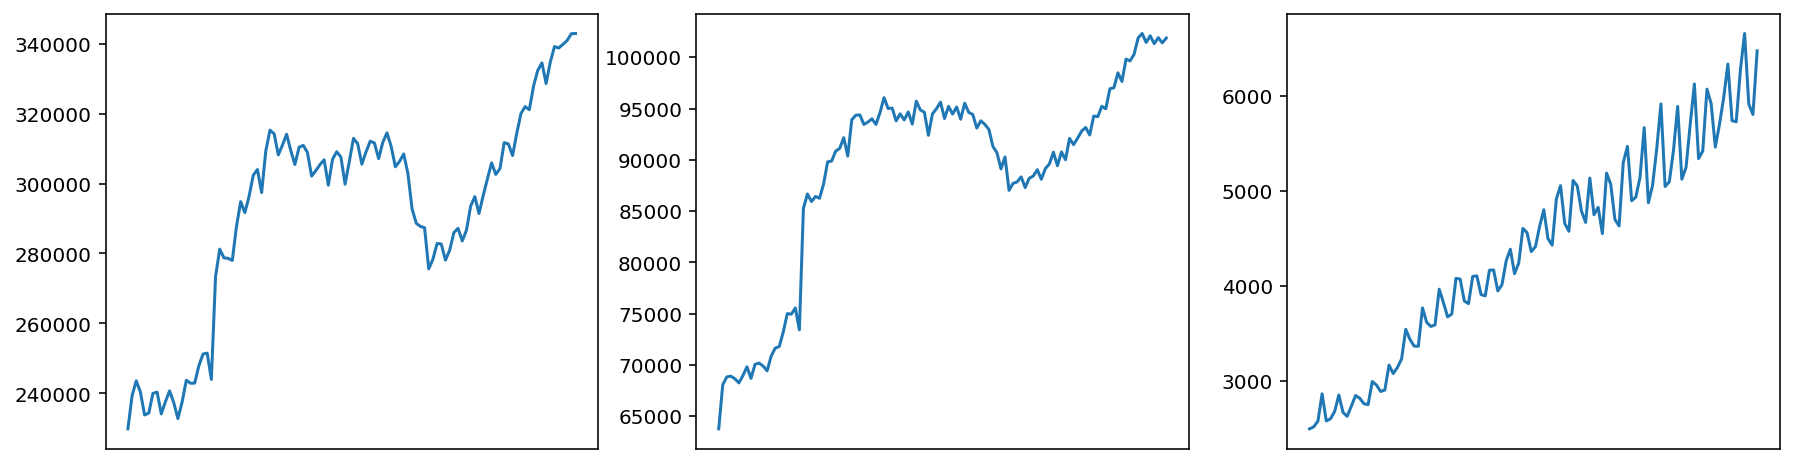

In [34]:
%config InlineBackend.figure_format ='retina'
#display time series values for a certain county and certain categorical variable value
x1 = raw_data.loc[(raw_data['geography'] == 6013) & (raw_data['firmsize'] == 0)]
xtick = x1['year']
x1 = x1['Emp']

x2 = raw_edu.loc[(raw_edu['geography'] == 6013) & (raw_edu['education'] == 'E4')]
x2 = x2['Emp']

x3 = raw_earns.loc[(raw_earns['geography'] == 6013)]
x3 = x3['EarnS']

fig, axs = plt.subplots(1,3,figsize = [15,4])

axs[0].plot(x1)
axs[0].set_xticks([])
axs[1].plot(x2) 
axs[1].set_xticks([])
axs[2].plot(x3)
axs[2].set_xticks([])

plt.show()

## 3.5 Reformatting

The original dataset does not have our interested variables, and the format of the original dataset is not feasible for further analysis. Therefore, we calcualte our interested variables and reformat some variables from long to wide.

In [35]:
#reformatting 

#get indexes and columns for the new DataFrame
county_index = raw_data.drop_duplicates(subset = ['geography'])['geography']
year_index = raw_data.drop_duplicates(subset = ['year'])['year']
columns_titles = ["geography","year","firmsize","quarter","Emp","EmpEnd"]
raw_data=raw_data.reindex(columns=columns_titles)

#group by three variables
grouped = raw_data.groupby(by=["geography","year","firmsize"])

#calculate yearly average net job creation rate and base period proportion of each firm size to avoid seasonality
result = []

for i in grouped.groups:
    
    a = grouped.get_group(i) # a is a DataFrame for a specific year
    county = a['geography'].values[0]
    year = a['year'].values[0]
    firm_size = a['firmsize'].values[0]
    prop = 0
    
    if firm_size == 0:  # all firm sizes
        total_emp_bgn = a['Emp'].values[0]   # first quarter beginning emp for the whole county
        total_emp_end = a['EmpEnd'].values[-1]   # last quarter ending emp for the whole county
        job_c = (total_emp_end - total_emp_bgn)/total_emp_bgn   # net job creation rate
        
    else:   # specific firm size
        emp_bgn = a['Emp'].values[0]   # first quarter emp for a specific firm size
        emp_end = a['EmpEnd'].values[-1]  #last quarter emp for a specific firm size
        
        if emp_bgn == 0:
            prop = (emp_end - emp_bgn) / 0.00001   # deal with the problem of dividing by zero
        else:
            prop = (emp_end - emp_bgn) / emp_bgn   # employment change rate 
    
    result.append([county,year,firm_size,prop,job_c])
    
result = pd.DataFrame(data=result,columns=['county','year','firmsize','prop','net_jc'])

result = result.loc[result['firmsize'] !=0]   # drop values for the whole county 
result = pd.get_dummies(result,columns =['firmsize'])   # turn firm size into dummy variable for the next step

In [36]:
#get knowledge contribution
grouped_edu = raw_edu.groupby(by=["geography","year","education"])

result_edu = []

for i in grouped_edu.groups:
    
    a = grouped_edu.get_group(i)
    county = a['geography'].values[0]
    year = a['year'].values[0]
    edu = a['education'].values[0]
    
    if edu == 'E0':     
        total_emp_bgn = a['Emp'].values[0]   # first quarter beginning emp for the whole county
        total_emp_end = a['EmpEnd'].values[-1]   # last quarter ending emp for the whole county
        
    else:
        emp_bgn = a['Emp'].values[0]   # first quarter emp for a specific firm size
        emp_end = a['EmpEnd'].values[-1]  #last quarter emp for a specific firm size
        
        if total_emp_bgn == 0:
            klg = emp_bgn / 0.00001   # deal with the problem of dividing by zero
            
        else:
            klg = emp_bgn / total_emp_bgn   # employment change rate 
            
        result_edu.append([klg])

#set multiindex on df_edu
edu_county_index = raw_edu.drop_duplicates(subset = ['geography'])['geography']
edu_year_index = raw_edu.drop_duplicates(subset = ['year'])['year']

mixid = pd.MultiIndex.from_product([edu_county_index,edu_year_index],names = ['county','year'])

df_edu = pd.DataFrame(result_edu,columns = ['klg_contribution'],index=mixid)

In [37]:
#get average change in earnins
grouped_earns = raw_earns.groupby(by = ['geography','year'])

result_earns = []

for i in grouped_earns.groups:
    
    a = grouped_earns.get_group(i)
    county = a['geography'].values[0]
    year = a['year'].values[0]
    
    earns_bgn = a['EarnS'].values[0]   # first quarter earnings
    earns_end = a['EarnS'].values[-1]   # last quarter eanings
    
    if earns_bgn == 0:
        earns = earns_bgn / 0.00001   # deal with the problem of dividing by zero
            
    else:
        earns = (earns_end - earns_bgn) / earns_bgn   # earnings change rate 
        
    result_earns.append([earns])
    
#set multiindex on df_earns
edu_county_index = raw_earns.drop_duplicates(subset = ['geography'])['geography']
edu_year_index = raw_earns.drop_duplicates(subset = ['year'])['year']

mixid = pd.MultiIndex.from_product([edu_county_index,edu_year_index],names = ['county','year'])

df_earns = pd.DataFrame(result_earns,columns = ['delta_earning'],index=mixid)

In [38]:
df_earns.head()

delta_earning
county year               
6001   1992       0.133280
       1993       0.172034
       1994       0.101124
       1995       0.076783
       1996       0.123061

In [39]:
#change variable firmsize from long to wide
grouped2 = result.groupby(['county','year'])
table = []

for i in grouped2.groups:
    
    row = []
    prop_1 = 0
    prop_size = []
    b = grouped2.get_group(i)
    net_jc = b['net_jc'].values[0]
    row =[net_jc]
    
    for j in ['firmsize_1','firmsize_2','firmsize_3','firmsize_4','firmsize_5']:
        
        firmsize_values = b[j].values
        
        if np.count_nonzero(firmsize_values) ==1:
            prop_1 = b.loc[b[j]==1]['prop'].values[0]
            row.append(prop_1)
            
        else:
            row.append(0)
            
    table.append(row)

#we use multiindex to make the DataFrame cleaner
mixid = pd.MultiIndex.from_product([county_index,year_index],names = ['county','year'])

df = pd.DataFrame(table,columns = ['net_jc','delta_prop_micro','delta_prop_small','delta_prop_medium','delta_prop_m_l','delta_prop_large'],index=mixid)

In [40]:
#display the DataFrames after cleaning and reformatting
df.head()

net_jc  delta_prop_micro  delta_prop_small  delta_prop_medium  \
county year                                                                    
6001   1992  0.013974          0.058444         -0.003391           0.001795   
       1993  0.034538          0.068279          0.018164           0.042341   
       1994  0.057106          0.082108          0.043424           0.054126   
       1995  0.059908          0.115817          0.073177           0.052790   
       1996  0.070784          0.112331          0.062600           0.065168   

             delta_prop_m_l  delta_prop_large  
county year                                    
6001   1992       -0.046937          0.009483  
       1993        0.151850          0.007936  
       1994        0.035065          0.052703  
       1995        0.090447          0.031200  
       1996        0.100023          0.053330

In [41]:
df_edu.head()

klg_contribution
county year                  
6001   1992          0.273974
       1993          0.281350
       1994          0.287659
       1995          0.289653
       1996          0.291270

In [42]:
df_earns.head()

delta_earning
county year               
6001   1992       0.133280
       1993       0.172034
       1994       0.101124
       1995       0.076783
       1996       0.123061

In [43]:
#merge df, df_edu, and df_earns
merged_edu = df.merge(df_edu, left_index=True, right_index=True)
merged = merged_edu.merge(df_earns, left_index=True, right_index=True)

In [44]:
#we want to check if merged DataFrame is correct
success = 'Correctly merged'

for i in merged.index:
    
    if (merged.loc[i,'klg_contribution'] != df_edu.loc[i,'klg_contribution'] 
        or merged.loc[i,'delta_earning'] != df_earns.loc[i,'delta_earning']):
        success = 'Failed merge'

print(success)

Correctly merged


In [45]:
#add dummy variable 'great_depression' indicating if the employment is suffering from the Great Depression
great_depression = []

for i in merged_edu.index:
    
    year = i[1]
    
    if year == 2007 or year == 2008 or year == 2009:
        great_depression.append(1)
        
    else: 
        great_depression.append(0)

merged['great_depression'] = great_depression 

#rename the merged DataFrame for convenience
df = merged

In [46]:
#display final result
df

net_jc  delta_prop_micro  delta_prop_small  delta_prop_medium  \
county year                                                                    
6001   1992  0.013974          0.058444         -0.003391           0.001795   
       1993  0.034538          0.068279          0.018164           0.042341   
       1994  0.057106          0.082108          0.043424           0.054126   
       1995  0.059908          0.115817          0.073177           0.052790   
       1996  0.070784          0.112331          0.062600           0.065168   
...               ...               ...               ...                ...   
6115   2014  0.044396          0.082382          0.042333           0.087129   
       2015  0.065660          0.051255          0.105664           0.037331   
       2016  0.059085          0.100956          0.031486          -0.027564   
       2017  0.049603          0.049885          0.157778           0.133333   
       2018  0.056088          0.050943          0.117342           0.081939   

             delta_prop_m_l  delta_prop_large  klg_contribution  \
county year                                                       
6001   1992       -0.046937          0.009483          0.273974   
       1993        0.151850          0.007936          0.281350   
       1994        0.035065          0.052703          0.287659   
       1995        0.090447          0.031200          0.289653   
       1996        0.100023          0.053330          0.291270   
...                     ...               ...               ...   
6115   2014       -0.142165          0.034599          0.205318   
       2015        0.053279          0.078955          0.206488   
       2016        0.024943          0.051615          0.206579   
       2017        0.110909         -0.018392          0.204319   
       2018        0.026178          0.037971          0.204679   

             delta_earning  great_depression  
county year                                   
6001   1992       0.133280                 0  
       1993       0.172034                 0  
       1994       0.101124                 0  
       1995       0.076783                 0  
       1996       0.123061                 0  
...                    ...               ...  
6115   2014       0.128406                 0  
       2015       0.121658                 0  
       2016       0.129640                 0  
       2017       0.103358                 0  
       2018       0.099131                 0  

[1485 rows x 9 columns]

# 4. Descriptive Statistical Analysis

In [47]:
#display the general descriptive statictics for each variable
df.describe()

,net_jc,delta_prop_micro,delta_prop_small,delta_prop_medium,delta_prop_m_l,delta_prop_large,klg_contribution,delta_earning,great_depression
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,0.036136,0.066868,0.024726,0.029312,0.022719,0.023529,0.194797,0.111774,0.111111
std,0.043116,0.057031,0.073582,0.088232,0.136479,0.073473,0.068686,0.081458,0.314376
min,-0.191525,-0.408311,-0.412860,-0.635226,-0.620690,-0.430704,0.084918,-0.266726,0.000000
25%,0.017575,0.040825,-0.005532,-0.003460,-0.018018,-0.003295,0.147326,0.074183,0.000000
50%,0.040241,0.069599,0.027032,0.028404,0.004982,0.023581,0.172498,0.109355,0.000000
75%,0.059031,0.093987,0.055598,0.060099,0.057792,0.050130,0.226385,0.152327,0.000000
max,0.276859,1.175204,0.887755,0.810811,2.315315,0.911111,0.425615,1.010067,1.000000


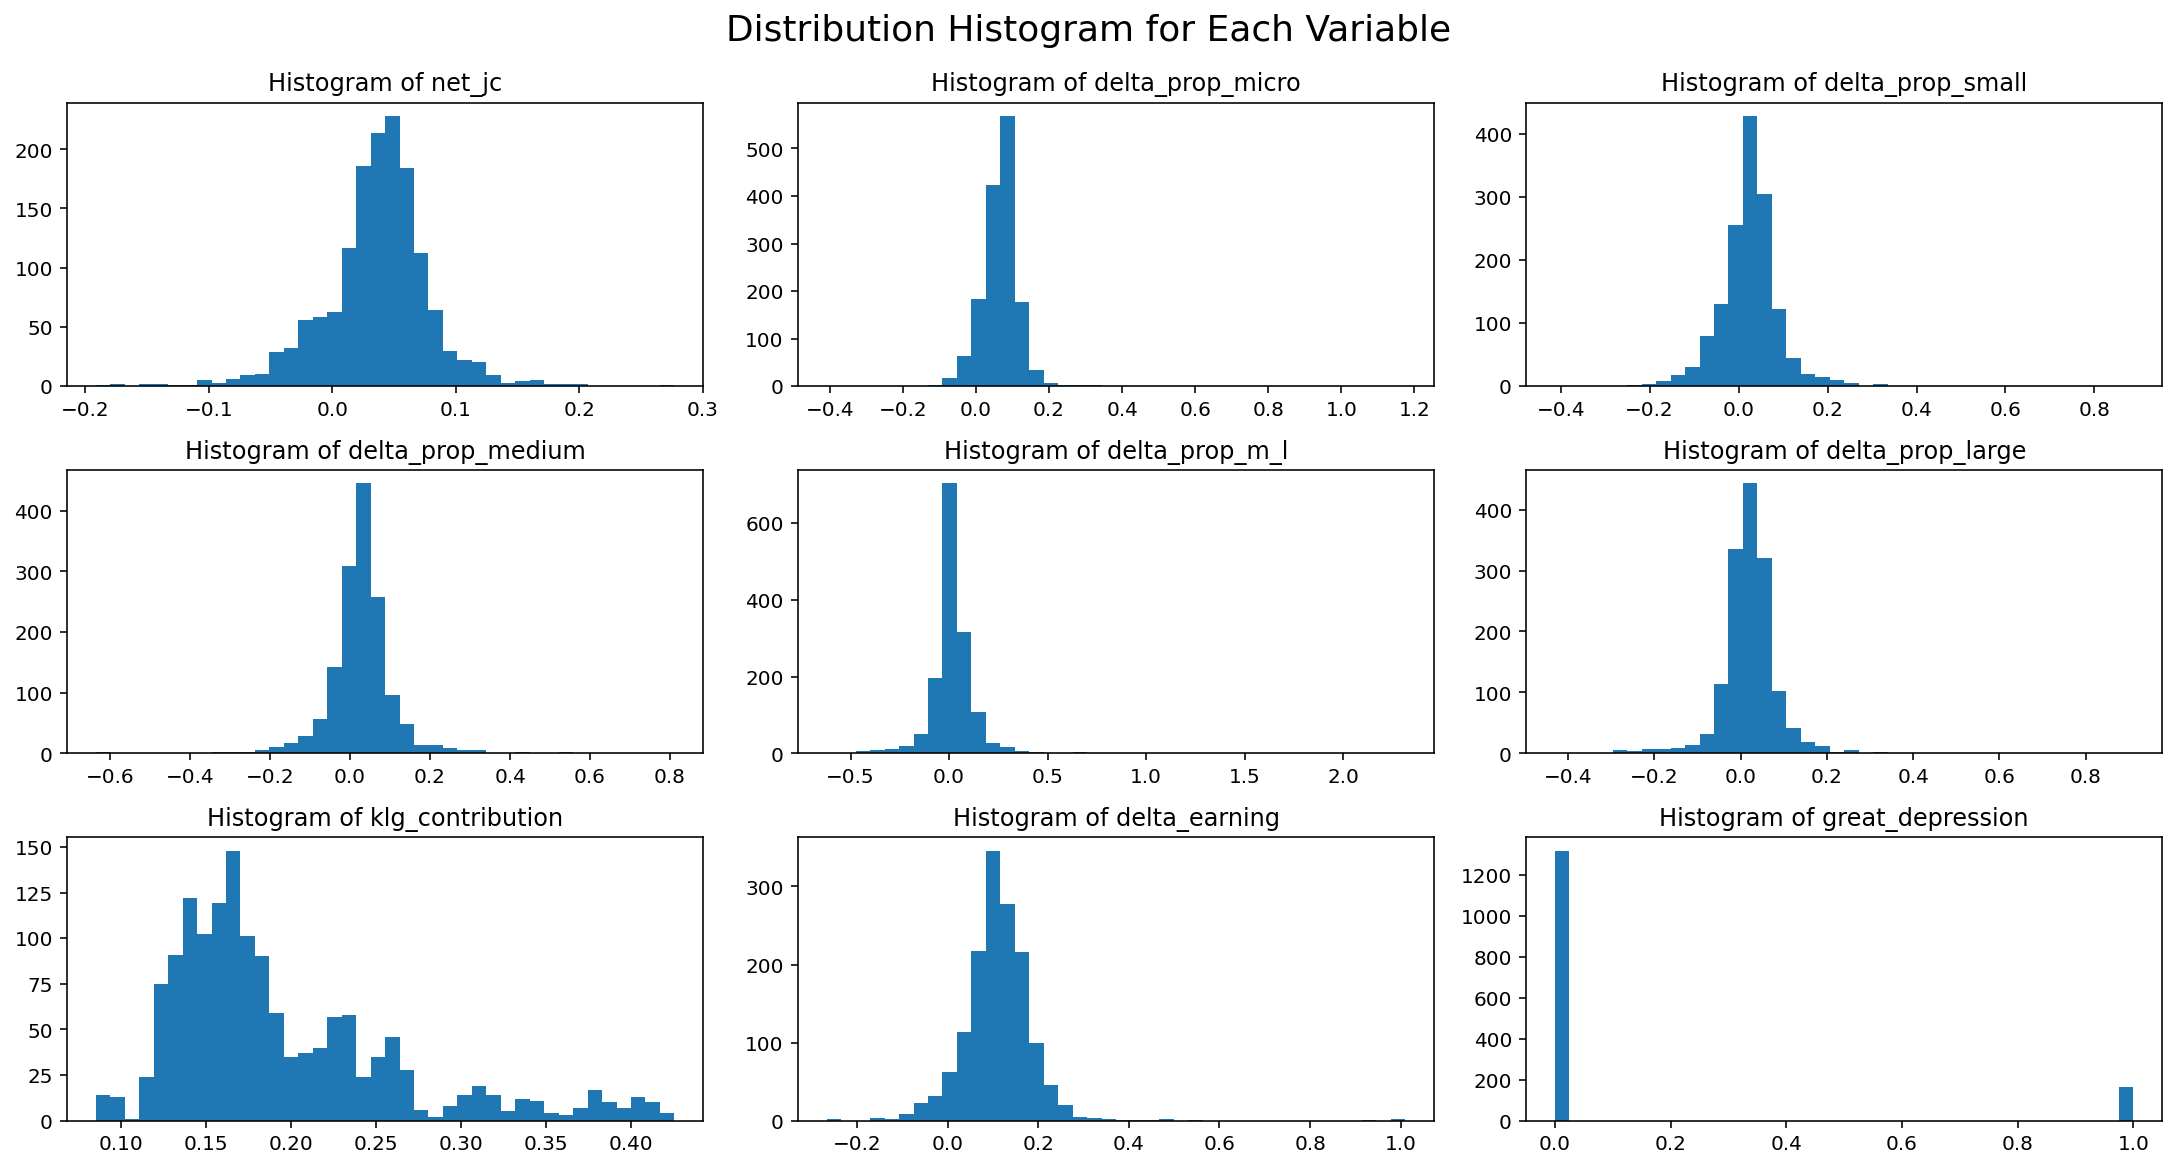

In [48]:
#display the distribution distogram for each variable
fig, axs = plt.subplots(3, 3, constrained_layout = True, figsize= [15,8])

fig.suptitle('Distribution Histogram for Each Variable',fontsize = 18)
count = 0
for i in df.columns:

    axs[int(count/3)][int(count%3)].hist(df[i],bins = 40)
    axs[int(count/3)][int(count%3)].set_title(f'Histogram of {i}')
    
    count+=1

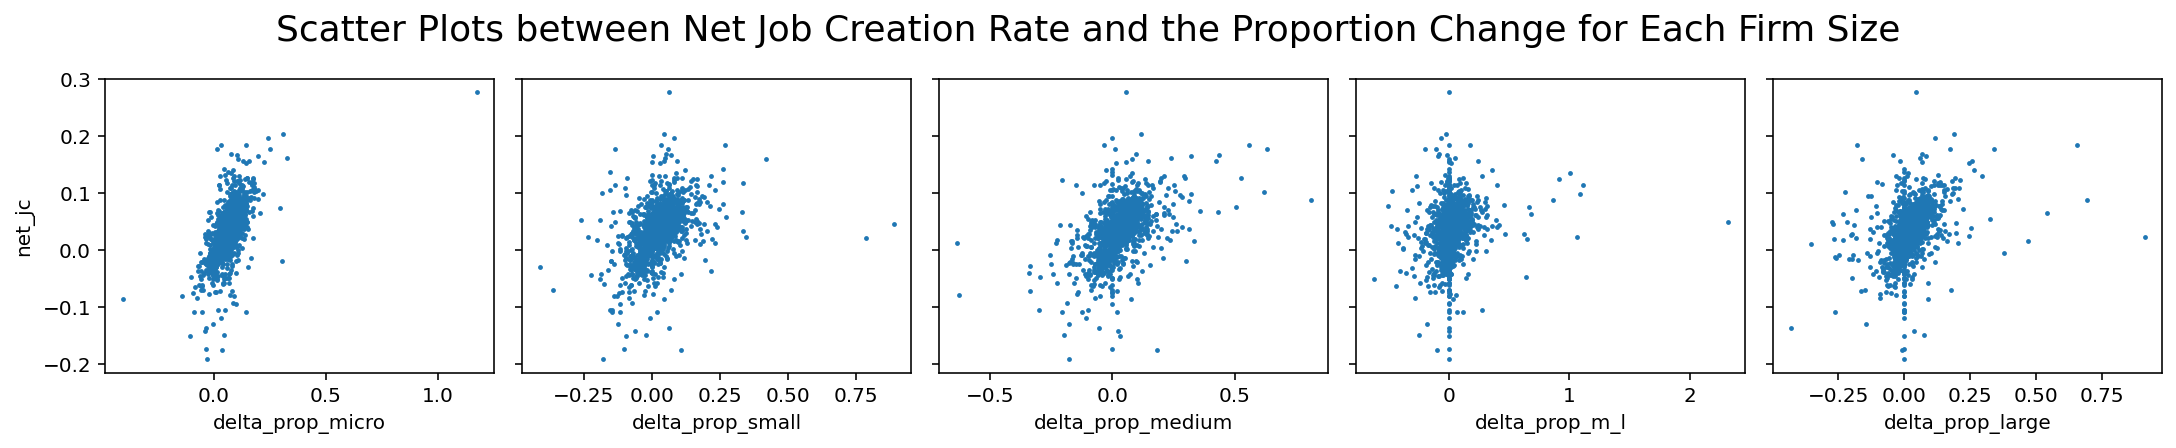

In [49]:
%config InlineBackend.figure_format ='retina'
#display scatter plots between net_jc and prop of each firm size
fig, axs = plt.subplots(1,5, constrained_layout = True,sharey = True, figsize= [15,3])

fig.suptitle('Scatter Plots between Net Job Creation Rate and the Proportion Change for Each Firm Size',fontsize = 18)
axs[0].set_ylabel('net_jc')

count = 0
for i in df.columns[1:6]:

    axs[count].scatter(df[i],df['net_jc'],s=2)
    axs[count].set_xlabel(i)
    
    count+=1

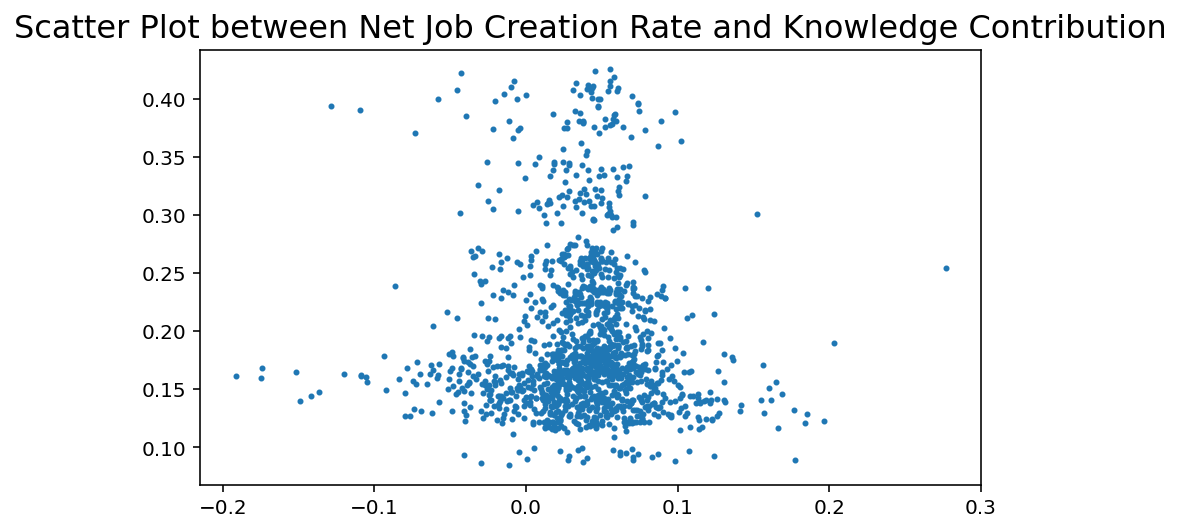

In [50]:
%config InlineBackend.figure_format ='retina'
#display scatter plot between net_jc and knowledge contribution
fig, ax = plt.subplots(1,1,figsize = [7,4])

ax.scatter(df['net_jc'],df['klg_contribution'],s=4)
ax.set_title('Scatter Plot between Net Job Creation Rate and Knowledge Contribution',fontsize = 16)

plt.show()

In [51]:
#display the correlations between each variable
df.corr()

,net_jc,delta_prop_micro,delta_prop_small,delta_prop_medium,delta_prop_m_l,delta_prop_large,klg_contribution,delta_earning,great_depression
net_jc,1.000000,0.616552,0.427167,0.487822,0.205833,0.394746,-0.034131,0.136723,-0.382908
delta_prop_micro,0.616552,1.000000,0.231917,0.202932,0.107528,0.095164,0.121521,-0.021135,-0.347572
delta_prop_small,0.427167,0.231917,1.000000,0.179506,0.072920,0.034408,0.001533,0.073281,-0.219650
delta_prop_medium,0.487822,0.202932,0.179506,1.000000,0.082258,0.029505,-0.039922,0.080606,-0.181326
delta_prop_m_l,0.205833,0.107528,0.072920,0.082258,1.000000,0.061467,0.023089,-0.032253,-0.135626
delta_prop_large,0.394746,0.095164,0.034408,0.029505,0.061467,1.000000,-0.023885,0.116477,-0.152285
klg_contribution,-0.034131,0.121521,0.001533,-0.039922,0.023089,-0.023885,1.000000,-0.274768,0.021868
delta_earning,0.136723,-0.021135,0.073281,0.080606,-0.032253,0.116477,-0.274768,1.000000,-0.112469
great_depression,-0.382908,-0.347572,-0.219650,-0.181326,-0.135626,-0.152285,0.021868,-0.112469,1.000000


In [52]:
#display the covariances
df.cov()

,net_jc,delta_prop_micro,delta_prop_small,delta_prop_medium,delta_prop_m_l,delta_prop_large,klg_contribution,delta_earning,great_depression
net_jc,0.001859,0.001516,0.001355,0.001856,0.001211,0.001250,-0.000101,0.000480,-0.005190
delta_prop_micro,0.001516,0.003252,0.000973,0.001021,0.000837,0.000399,0.000476,-0.000098,-0.006232
delta_prop_small,0.001355,0.000973,0.005414,0.001165,0.000732,0.000186,0.000008,0.000439,-0.005081
delta_prop_medium,0.001856,0.001021,0.001165,0.007785,0.000991,0.000191,-0.000242,0.000579,-0.005030
delta_prop_m_l,0.001211,0.000837,0.000732,0.000991,0.018626,0.000616,0.000216,-0.000359,-0.005819
delta_prop_large,0.001250,0.000399,0.000186,0.000191,0.000616,0.005398,-0.000121,0.000697,-0.003517
klg_contribution,-0.000101,0.000476,0.000008,-0.000242,0.000216,-0.000121,0.004718,-0.001537,0.000472
delta_earning,0.000480,-0.000098,0.000439,0.000579,-0.000359,0.000697,-0.001537,0.006635,-0.002880
great_depression,-0.005190,-0.006232,-0.005081,-0.005030,-0.005819,-0.003517,0.000472,-0.002880,0.098832


# 5. Regression Analysis
In this session, we will use different different OLS regression models to test the significance of coefficients of delta_prop_micro and delta_prop_small. We will include different sets of controlled variables in each model in order to minimize the possibility of omitting important variables. After all models, we will compare the diagonistic parameters to see if including certain set of controlled variable will increase the efficiency of the model and how it impacts the coefficient on each regressor.   

## 5.1 Model 1 (Regressors Only)
In this model, we will only include the regressors and no other controlled variables. 

In [53]:
#set up the dependent variable 'net_jc' and two regressors with constant
y = df['net_jc']
x = df[['delta_prop_micro','delta_prop_small']]
x = sm.add_constant(x)

#set up the OLS model
model = sm.OLS(y,x)

result_1 = model.fit()

## 5.2 Model 2 (With the First Set of Controlled Variables)
In this model, we will include the first set of controlled variables. It includes the change of the employment proportion for other firm sizes.

In [54]:
#set up the dependent variable 'net_jc' and two regressors with controlled variables and constant
y = df['net_jc']
x = df[['delta_prop_micro','delta_prop_small','delta_prop_medium','delta_prop_m_l','delta_prop_large']]
x = sm.add_constant(x)

#set up the OLS model
model = sm.OLS(y,x)

result_2 = model.fit()

## 5.3 Model 3 (With the Knowledge Contribution)
In this model, we will include another controlled variable which is the knowledge contribution.

In [55]:
#set up the dependent variable 'net_jc' and two regressors with controlled variables and constant
y = df['net_jc']
x = df[['delta_prop_micro','delta_prop_small','delta_prop_medium','delta_prop_m_l','delta_prop_large','klg_contribution']]
x = sm.add_constant(x)

#set up the OLS model
model = sm.OLS(y,x)

result_3 = model.fit()

## 5.4 Model 4 (With the Great Depression)
In this model, we will include one dummy variable which indicates whether the market is suffering from the Great Depression.

In [56]:
#set up the dependent variable 'net_jc' and two regressors with controlled variables and constant
y = df['net_jc']
x = df[['delta_prop_micro','delta_prop_small','delta_prop_medium','delta_prop_m_l','delta_prop_large','klg_contribution','great_depression']]
x = sm.add_constant(x)

#set up the OLS model
model = sm.OLS(y,x)

result_4 = model.fit()

## 5.5 Model 5 (With the Earning Change Rate)
In this model, we will include another controlled variable which is the change rate in earnings.

In [57]:
#set up the dependent variable 'net_jc' and two regressors with controlled variables and constant
y = df['net_jc']
x = df[['delta_prop_micro','delta_prop_small','delta_prop_medium','delta_prop_m_l','delta_prop_large','klg_contribution','great_depression','delta_earning']]
x = sm.add_constant(x)

#set up the OLS model
model = sm.OLS(y,x)

result_5 = model.fit()

In [58]:
#display the summary for regression models
models = [result_1,result_2,result_3,result_4,result_5]
model_names = []

for i in range(5):

    model_names.append(f'Model{i+1}')
    
regressors = (df.columns[1:].values)
regressors = ['const']+(regressors.tolist())


summary = summary_col(models, model_names = model_names, stars = True, regressor_order = regressors)
print(summary)


                    Model1    Model2    Model3     Model4     Model5  
----------------------------------------------------------------------
const             0.0041*** -0.0002   0.0082***  0.0098***  0.0053**  
                  (0.0013)  (0.0010)  (0.0019)   (0.0020)   (0.0024)  
delta_prop_micro  0.4135*** 0.3408*** 0.3484***  0.3364***  0.3382*** 
                  (0.0148)  (0.0114)  (0.0114)   (0.0119)   (0.0119)  
delta_prop_small  0.1760*** 0.1433*** 0.1424***  0.1383***  0.1368*** 
                  (0.0114)  (0.0088)  (0.0087)   (0.0087)   (0.0087)  
delta_prop_medium           0.1638*** 0.1615***  0.1592***  0.1579*** 
                            (0.0073)  (0.0072)   (0.0072)   (0.0072)  
delta_prop_m_l              0.0290*** 0.0294***  0.0279***  0.0287*** 
                            (0.0046)  (0.0046)   (0.0046)   (0.0045)  
delta_prop_large            0.1924*** 0.1909***  0.1873***  0.1845*** 
                            (0.0085)  (0.0084)   (0.0085)   (0.0085)  
klg_c

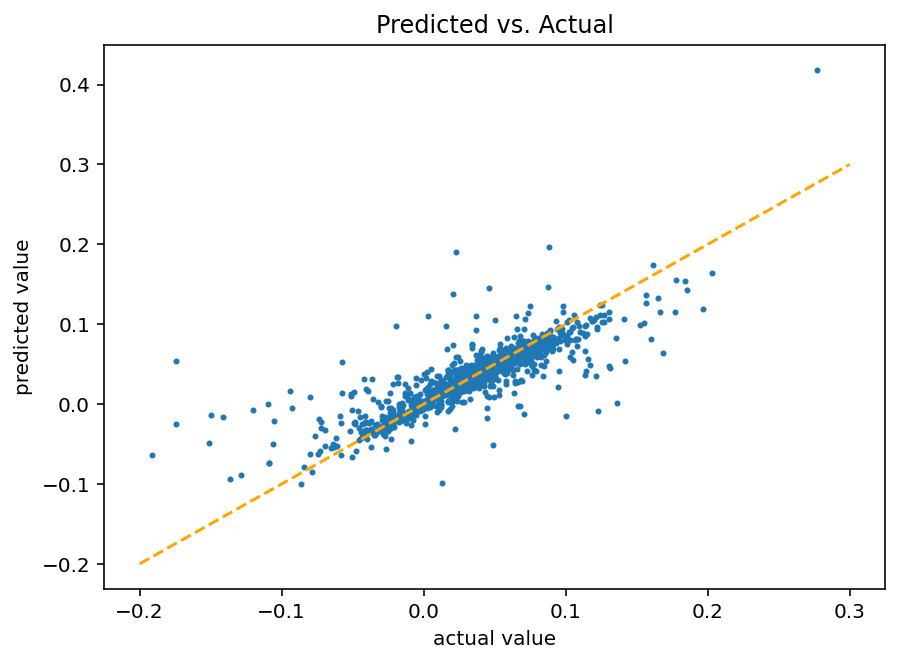

In [59]:
%config InlineBackend.figure_format ='retina'
#predicted vs. actual
actual = df['net_jc']
predicted = result_5.predict()

fig, ax = plt.subplots(figsize = [7,5])

ax.scatter(actual, predicted, s = 4)
ax.set_xlabel('actual value')
ax.set_ylabel('predicted value')
ax.set_title('Predicted vs. Actual')

x = np.linspace(-2,3)/10
y = np.linspace(-2,3)/10

plt.plot(x,y,'--',c='orange',markersize=2)
plt.show()

## 5.6 Regression Diagnostics

In [60]:
#test for linearity
name = ['t value', 'p value']
test = sms.linear_harvey_collier(result_1)
lzip(name, test)

[('t value', -0.5070794197290004), ('p value', 0.6121745864794319)]

In [61]:
#test for heterosketasticity
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(result_5.resid, result_5.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 48.34927329478317),
 ('p-value', 8.47095172993446e-08),
 ('f-value', 6.209192503835241),
 ('f p-value', 6.485475457475074e-08)]

In [62]:
#test for normality of residuels
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(result_5.resid)
lzip(test,name)

[(19554.34415224742, 'Jarque-Bera'),
 (0.0, 'Chi^2 two-tail prob.'),
 (-1.646750259526991, 'Skew'),
 (20.46947792041186, 'Kurtosis')]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


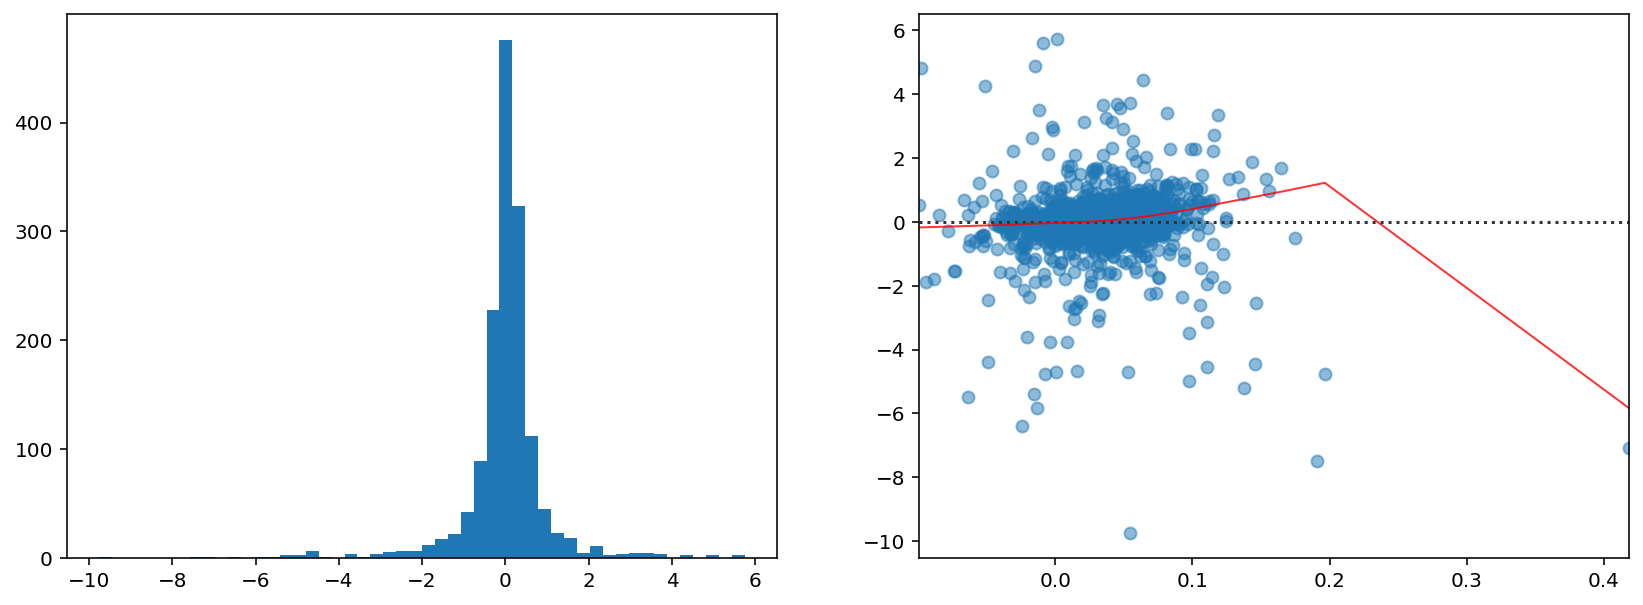

In [63]:
%config InlineBackend.figure_format ='retina'
#plot histogram of normalized residuels and scatter plot of normalized residuels vs. fitted values
normalized_resid = result_5.get_influence().resid_studentized_internal
fig, axs = plt.subplots(1,2,figsize = [14,5])

axs[0].hist(normalized_resid, bins = 50)

axs[1] = sns.residplot(result_5.fittedvalues, normalized_resid,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})


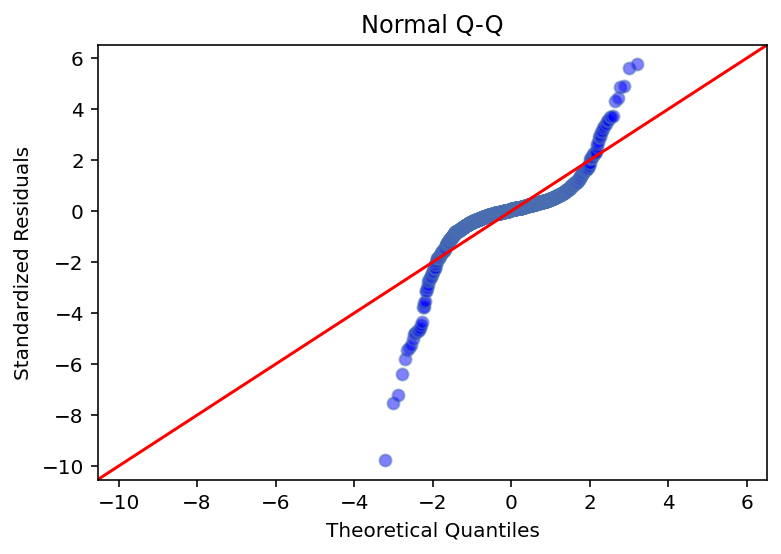

In [64]:
%config InlineBackend.figure_format ='retina'
#plot quantile-quantile plot
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(normalized_resid))

QQ = ProbPlot(normalized_resid)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');


In [65]:
df['net_jc'].describe()

count    1485.000000
mean        0.036136
std         0.043116
min        -0.191525
25%         0.017575
50%         0.040241
75%         0.059031
max         0.276859
Name: net_jc, dtype: float64

In [66]:
std = df['net_jc'].std()
mean = df['net_jc'].mean()

In [67]:
outliers = df.loc[(df['net_jc'] >= (mean+3*std)) | (df['net_jc'] <= (mean-3*std))]

In [68]:
df_no_outlier = df.drop(index = outliers.index)

In [69]:
df_no_outlier['net_jc'].max()

0.16471175442974795

In [70]:
y = df_no_outlier['net_jc']
x = df_no_outlier[['delta_prop_micro','delta_prop_small','delta_prop_medium','delta_prop_m_l','delta_prop_large','klg_contribution','great_depression','delta_earning']]
x = sm.add_constant(x)

#set up the OLS model
model = sm.OLS(y,x)

result_6 = model.fit()

In [71]:
models = [result_1,result_2,result_3,result_4,result_5,result_6]
model_names = []

for i in range(6):

    model_names.append(f'Model{i+1}')
    
regressors = (df_no_outlier.columns[1:].values)
regressors = ['const']+(regressors.tolist())


summary = summary_col(models, model_names = model_names, stars = True, regressor_order = regressors)
print(summary)


                    Model1    Model2    Model3     Model4     Model5     Model6  
---------------------------------------------------------------------------------
const             0.0041*** -0.0002   0.0082***  0.0098***  0.0053**   0.0091*** 
                  (0.0013)  (0.0010)  (0.0019)   (0.0020)   (0.0024)   (0.0021)  
delta_prop_micro  0.4135*** 0.3408*** 0.3484***  0.3364***  0.3382***  0.3680*** 
                  (0.0148)  (0.0114)  (0.0114)   (0.0119)   (0.0119)   (0.0123)  
delta_prop_small  0.1760*** 0.1433*** 0.1424***  0.1383***  0.1368***  0.1212*** 
                  (0.0114)  (0.0088)  (0.0087)   (0.0087)   (0.0087)   (0.0075)  
delta_prop_medium           0.1638*** 0.1615***  0.1592***  0.1579***  0.1398*** 
                            (0.0073)  (0.0072)   (0.0072)   (0.0072)   (0.0064)  
delta_prop_m_l              0.0290*** 0.0294***  0.0279***  0.0287***  0.0277*** 
                            (0.0046)  (0.0046)   (0.0046)   (0.0045)   (0.0038)  
delta_prop_larg

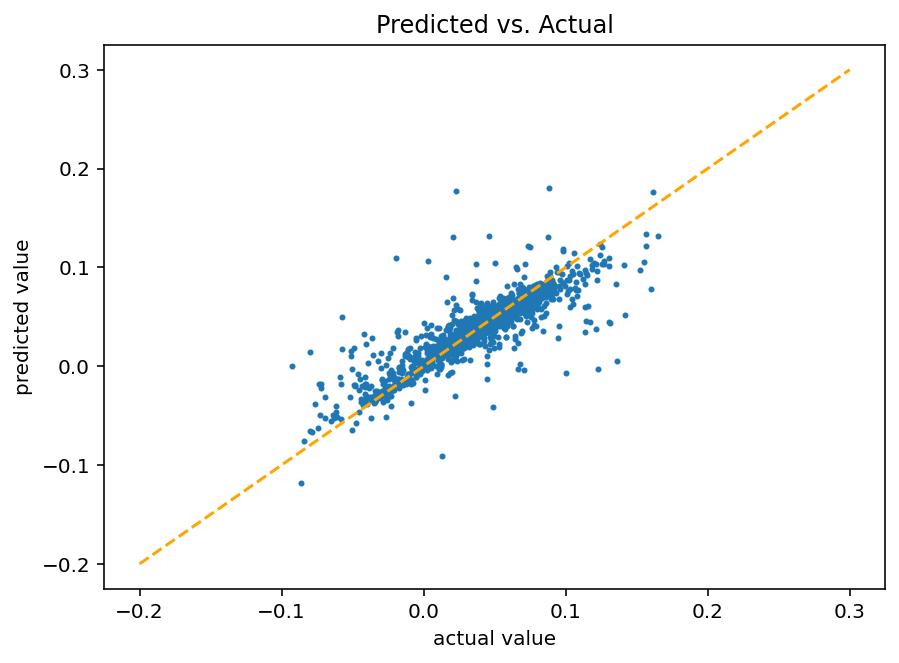

In [72]:
%config InlineBackend.figure_format ='retina'
#predicted vs. actual
actual = df_no_outlier['net_jc']
predicted = result_6.predict()

fig, ax = plt.subplots(figsize = [7,5])

ax.scatter(actual, predicted, s = 4)
ax.set_xlabel('actual value')
ax.set_ylabel('predicted value')
ax.set_title('Predicted vs. Actual')

x = np.linspace(-2,3)/10
y = np.linspace(-2,3)/10

plt.plot(x,y,'--',c='orange',markersize=2)
plt.show()

In [73]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(result_6.resid)
lzip(test,name)

[(9163.162916952111, 'Jarque-Bera'),
 (0.0, 'Chi^2 two-tail prob.'),
 (-0.28573015654566336, 'Skew'),
 (15.25551589853906, 'Kurtosis')]

In [74]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(result_6.resid, result_6.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 77.84377678766441),
 ('p-value', 1.3266335387434635e-13),
 ('f-value', 10.214786478817096),
 ('f p-value', 5.709972818845741e-14)]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


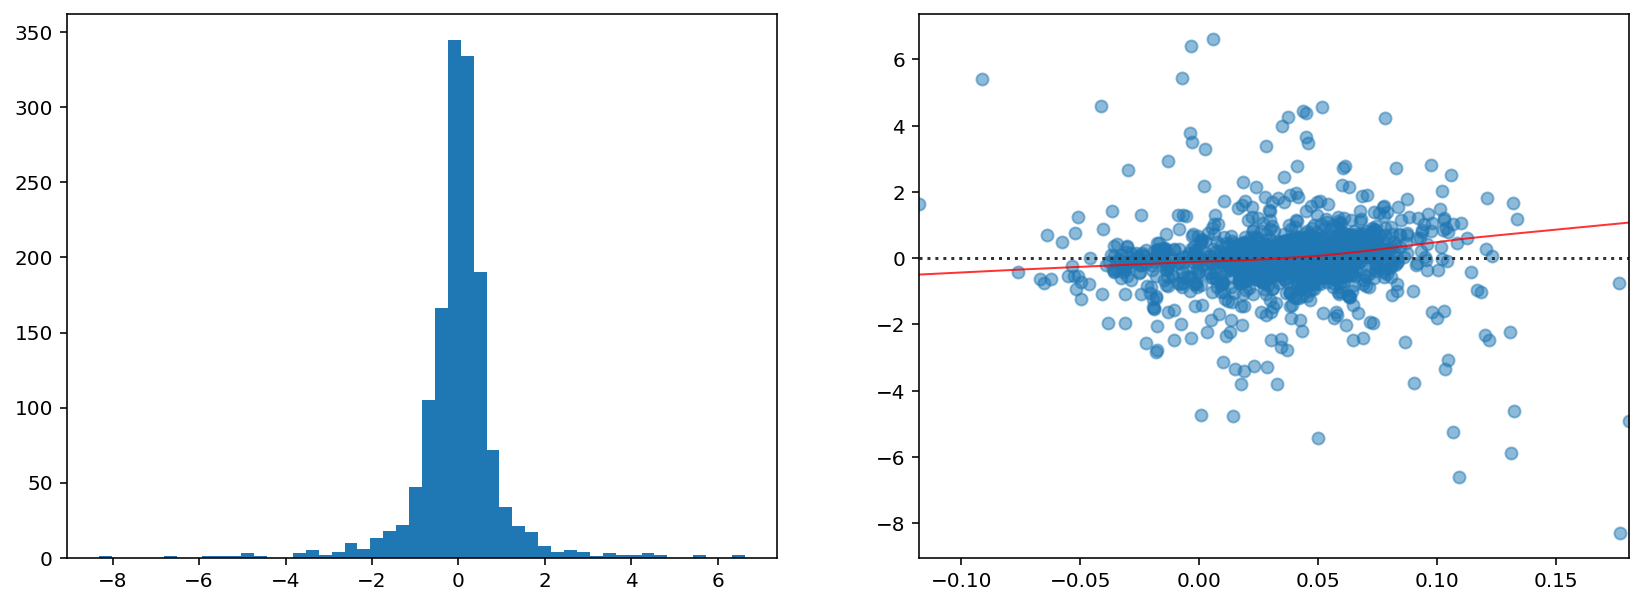

In [75]:
%config InlineBackend.figure_format ='retina'
#plot histogram of normalized residuels and scatter plot of normalized residuels vs. fitted values
normalized_resid = result_6.get_influence().resid_studentized_internal
fig, axs = plt.subplots(1,2,figsize = [14,5])

axs[0].hist(normalized_resid, bins = 50)

axs[1] = sns.residplot(result_6.fittedvalues, normalized_resid,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

In [76]:
net_jc = df['net_jc']

In [77]:
net_jc.sort_values(ascending = False)

county  year
6067    1998    0.276859
6005    2014    0.203327
6011    1995    0.196648
6027    1993    0.185149
6011    1998    0.183881
                  ...   
6027    1992   -0.149340
6051    2009   -0.151425
        2011   -0.174386
6043    2016   -0.174508
6051    1995   -0.191525
Name: net_jc, Length: 1485, dtype: float64